<a href="https://colab.research.google.com/github/shreyab375/LSTM-Forecasting-Models-/blob/main/CNN%2BLSTM%2BAttention_Models_for_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

In [21]:
#Reade the data
df_sn=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snv1_full.csv', sep=",", header=0)
#convert the date to datetime format
df_sn.Date = pd.to_datetime(df_sn.Date)

In [22]:
#Select the values from 1900 to avoid any data gaps
df_sn = df_sn.set_index('Date')
df_sn = df_sn.truncate(before = '1900-01-01', after ='2024-01-01')
df_sn = df_sn.reset_index()

In [23]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df_sn)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df_sn[:n_train].drop(columns='Date').values
train_date = df_sn[:n_train].drop(columns=['Sn'])

val_data   = df_sn[n_train:n_train+n_val].drop(columns='Date').values
val_date   = df_sn[n_train:n_train+n_val].drop(columns=['Sn'])

test_data  = df_sn[-n_test:].drop(columns=['Date']).values
test_date  = df_sn[-n_test:].drop(columns=['Sn'])


In [24]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  33723
Validation Set :  4215
Test Set       :  4216


In [25]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [26]:
#Step 5
# Prediction intervals
ten_days = 10
hundred_days = 100
one_year = 365
ten_years = 3650

# Prepare the datasets
ten_day_date = test_date.head(ten_days)
ten_day_data = test_data[:ten_days]

hundred_day_date = test_date.head(hundred_days)
hundred_day_data = test_data[:hundred_days]

one_year_date = test_date.head(one_year)
one_year_data = test_data[:one_year]

ten_year_date = test_date.head(ten_years)
ten_year_data = test_data[:ten_years]

In [27]:
#Step 6
#Create a windowed dataset for training
# Assume test_data is your feature (e.g., SN) and is a numpy array
def reshape_data(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [28]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[ 7.],
       [ 7.],
       [ 2.],
       ...,
       [97.],
       [89.],
       [80.]])

In [29]:
#Step 7
#Let's create a time step of 10 days
## Example: Predict for 10 days (using 10 days history to predict the next day)
time_steps = 10
X_train, y_train = reshape_data(train_data, time_steps)
X_val, y_val     = reshape_data(val_data, time_steps)
X_test, y_test   = reshape_data(test_data, time_steps)

In [30]:
#Step 8
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)


In [31]:

#Step 8
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [32]:
# Example: Input shape = (time steps, features)
input_shape = (10, 1)  # Modify for different horizons (e.g., 10 days, 100 days, etc.)

model = Sequential([
    Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
    Conv1D(filters=8, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [33]:
#Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.Huber(),
              metrics= [RootMeanSquaredError(), cc])

In [34]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/100
2108/2108 [==============================] - 104s 40ms/step - loss: 0.3358 - root_mean_squared_error: 0.9100 - cc: nan - val_loss: 0.1021 - val_root_mean_squared_error: 0.4556 - val_cc: nan
Epoch 2/100
2108/2108 [==============================] - 49s 23ms/step - loss: 0.1081 - root_mean_squared_error: 0.4756 - cc: nan - val_loss: 0.0792 - val_root_mean_squared_error: 0.4003 - val_cc: nan
Epoch 3/100
2108/2108 [==============================] - 58s 27ms/step - loss: 0.0881 - root_mean_squared_error: 0.4259 - cc: nan - val_loss: 0.0769 - val_root_mean_squared_error: 0.3934 - val_cc: nan
Epoch 4/100
2108/2108 [==============================] - 53s 25ms/step - loss: 0.0682 - root_mean_squared_error: 0.3722 - cc: nan - val_loss: 0.0621 - val_root_mean_squared_error: 0.3526 - val_cc: nan
Epoch 5/100
2108/2108 [==============================] - 36s 17ms/step - loss: 0.0517 - root_mean_squared_error: 0.3229 - cc: nan - val_loss: 0.0358 - val_root_mean_squared_error: 0.2677 - val_cc

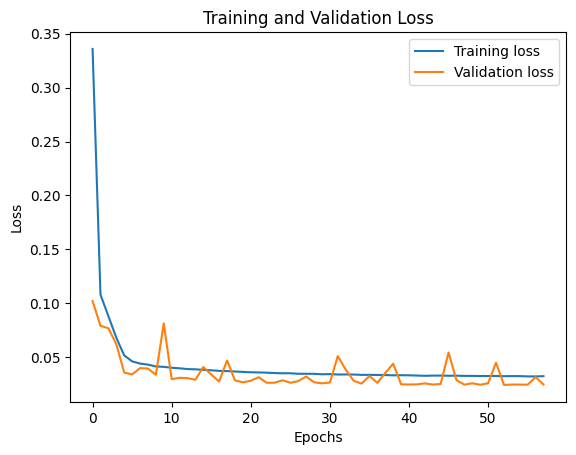

In [36]:
# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

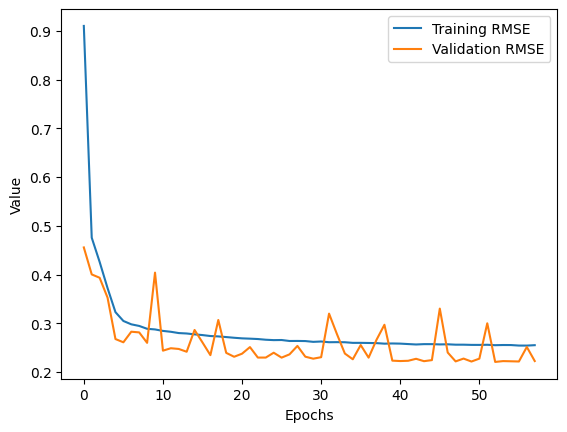

In [37]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [38]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

132/132 [==============================] - 6s 12ms/step


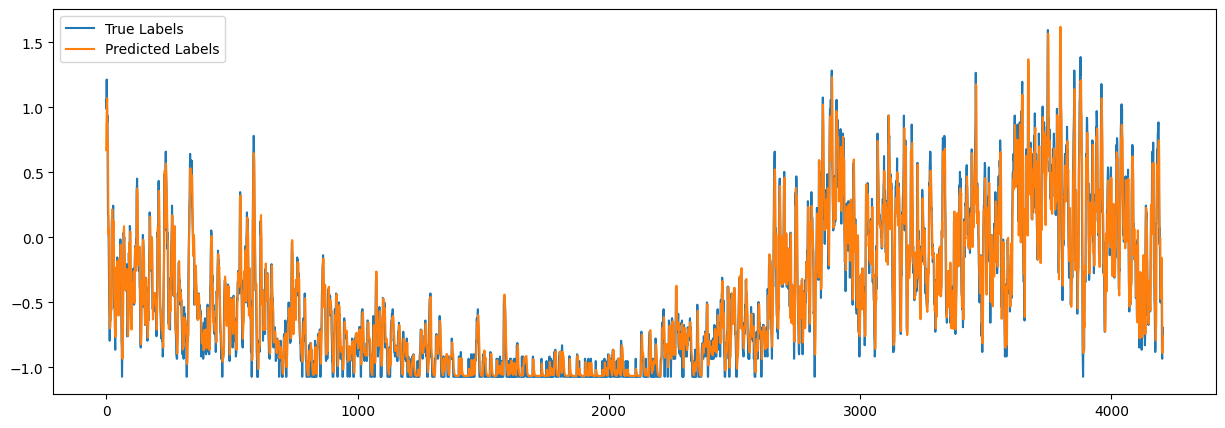

In [39]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [40]:
#Step 9
#Evaluate the model on the 10, 100, 356 Days to Forecast
X_ten   = X_test[:10]
X_hundred = X_test[:100]
X_year = X_test[:365]

y_ten   = y_test[:10]
y_hundred = y_test[:100]
y_year = y_test[:365]

print("10 Day to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_ten, y_ten)
y_pred_ten = model.predict(X_ten)


print("100 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_hundred, y_hundred)
y_pred_hundred = model.predict(X_hundred)

print("365 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_year, y_year)
y_pred_year = model.predict(X_year)

10 Day to Forecast
1/1 [==============================] - 0s 23ms/step
100 Days to Forecast
4/4 [==============================] - 0s 6ms/step
365 Days to Forecast
12/12 [==============================] - 0s 5ms/step


In [41]:
#Step 10
#Inverse from scaled data
inv_pred_ten = scaler.inverse_transform(y_pred_ten)
inv_ten      = scaler.inverse_transform(y_ten)

inv_pred_hundred = scaler.inverse_transform(y_pred_hundred)
inv_hundred      = scaler.inverse_transform(y_hundred)

inv_pred_year = scaler.inverse_transform(y_pred_year)
inv_year     = scaler.inverse_transform(y_year)

#Copy data date
viz_ten   = ten_day_date.copy()
viz_hundred = hundred_day_date.copy()
viz_year = one_year_date.copy()

#Join true and predicted data
viz_ten['sn_pred'] = inv_pred_ten
viz_ten['sn_true'] = inv_ten

viz_hundred['sn_pred'] = inv_pred_hundred
viz_hundred['sn_true'] = inv_hundred

viz_year['sn_pred'] = inv_pred_year
viz_year['sn_true'] = inv_year

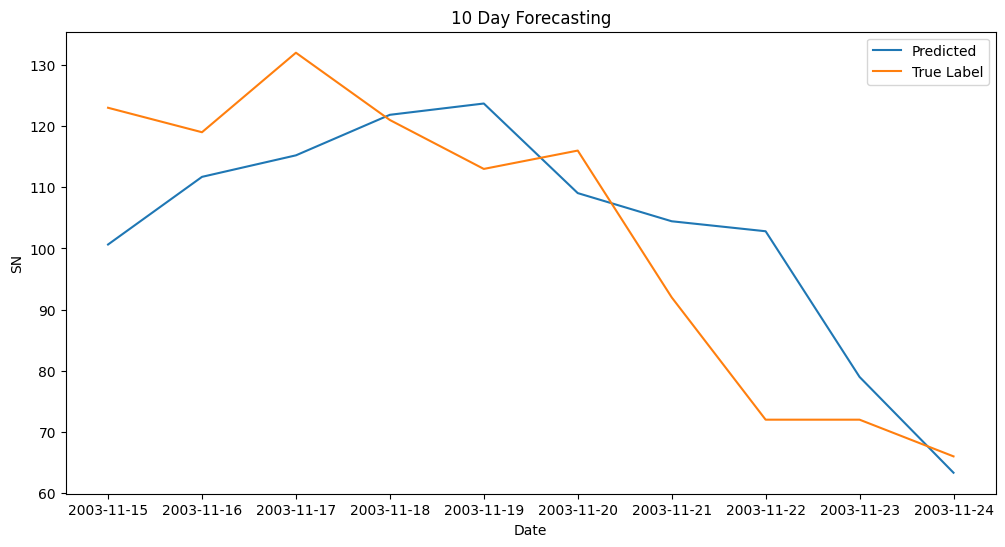

In [42]:
#10 Day Forecasting

# Load dataset
viz_ten = viz_ten.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_ten.index, viz_ten['sn_pred'], label='Predicted')
ax.plot(viz_ten.index, viz_ten['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('10 Day Forecasting')
ax.legend()

# Show plot
plt.show()

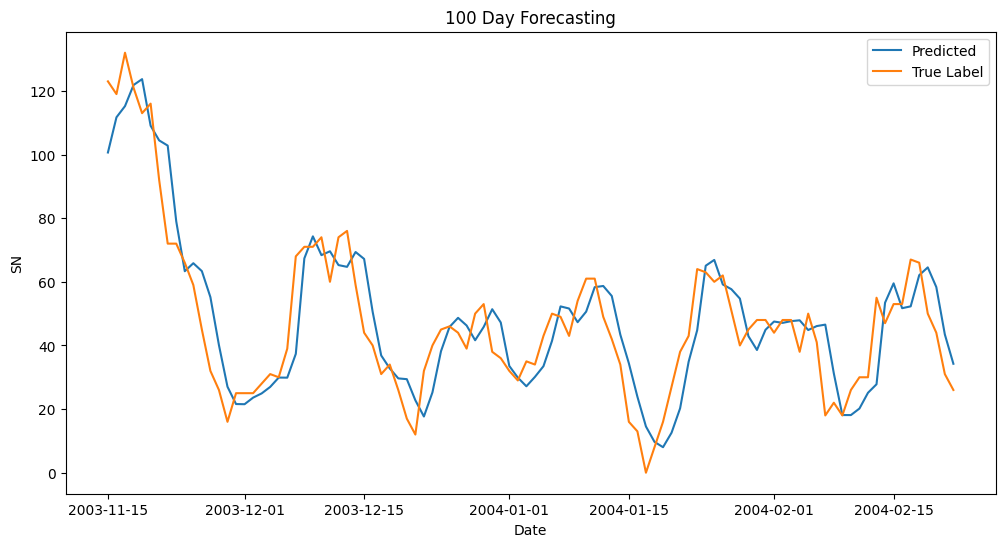

In [43]:
#100 Days Forecasting

# Load dataset
viz_hundred = viz_hundred.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_hundred.index, viz_hundred['sn_pred'], label='Predicted')
ax.plot(viz_hundred.index, viz_hundred['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('100 Day Forecasting')
ax.legend()

# Show plot
plt.show()


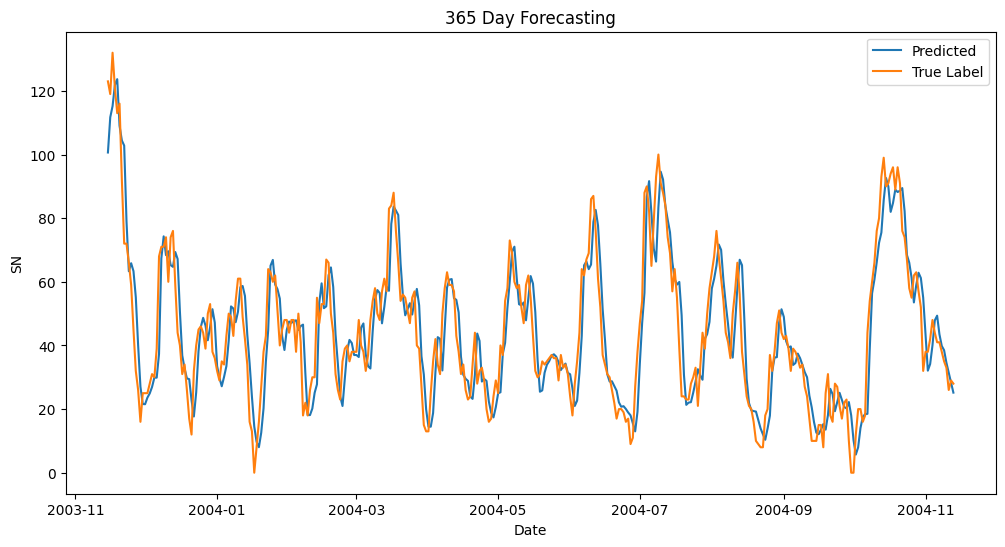

In [44]:
#365 Days Forecasting

# Load dataset
viz_year = viz_year.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_year.index, viz_year['sn_pred'], label='Predicted')
ax.plot(viz_year.index, viz_year['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('365 Day Forecasting')
ax.legend()

# Show plot
plt.show()




In [45]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Final.h5')

# Save the history object
with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Final.pkl', 'wb') as f:
    pickle.dump(history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
#Use Model To Forecasting
#Load Library, Model, and Addition First
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))

In [47]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 100 # 100 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

4/4 [==============================] - 0s 6ms/step


In [48]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)

In [49]:
#4. Copy Dataframe
viz = df_sn.copy()

In [50]:
#5. Generate new forecasting date
from prophet import Prophet
m = Prophet()

viz = viz.rename(columns={'Date': 'ds', 'Sn' : 'y'})

m.fit(viz)
future = m.make_future_dataframe(periods=n_steps, freq='D', include_history=False)
future

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfb3ipmoy/40374ujg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfb3ipmoy/3ab71ksk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12642', 'data', 'file=/tmp/tmpfb3ipmoy/40374ujg.json', 'init=/tmp/tmpfb3ipmoy/3ab71ksk.json', 'output', 'file=/tmp/tmpfb3ipmoy/prophet_modelsw1e26pw/prophet_model-20240827124636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2015-06-01
1,2015-06-02
2,2015-06-03
3,2015-06-04
4,2015-06-05
...,...
95,2015-09-04
96,2015-09-05
97,2015-09-06
98,2015-09-07


In [51]:
#6. Merge Forecasting Date and Data
future['Sn'] = inv_data
future = future.rename(columns={'ds': 'Date'})
future

,Date,Sn
0,2015-06-01,54.889523
1,2015-06-02,39.609009
2,2015-06-03,29.360981
3,2015-06-04,24.827900
4,2015-06-05,24.924522
...,...,...
95,2015-09-04,40.736481
96,2015-09-05,23.458981
97,2015-09-06,10.555027
98,2015-09-07,14.010017


In [52]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 100 days

hist_data = df_sn.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [53]:
#8. Set Index
hist_data = hist_data.set_index('Date')
future_data = future.set_index('Date')


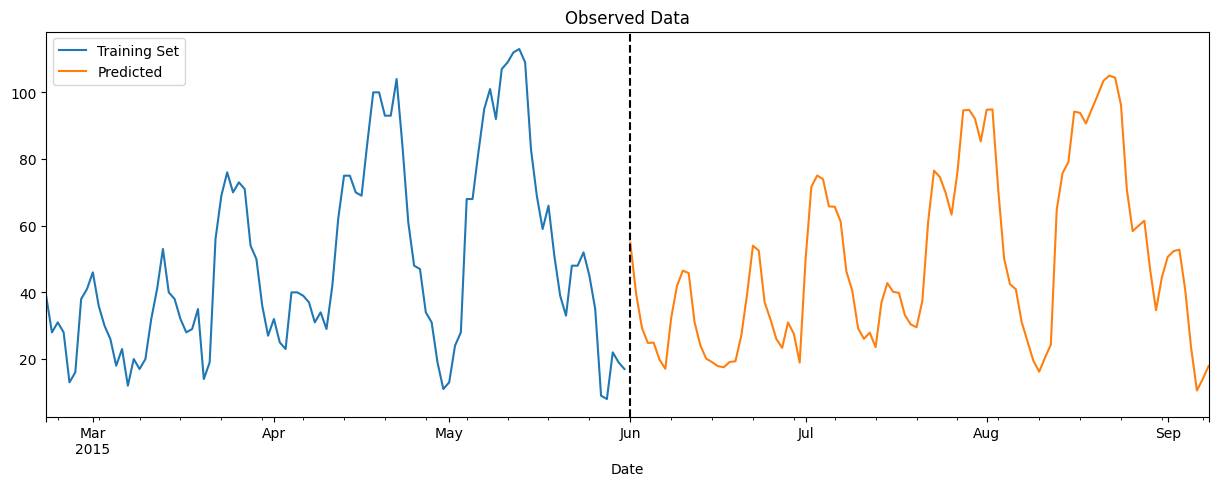

In [54]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
future_data.plot(ax=ax, label='Predicted')
ax.axvline('2015-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()